## Week 3 : Logistic Regression 
```
- Machine Learning, Innopolis University (Fall semester 2024)
- Instructors: Adil Khan & Gcinizwe Dlamini
```
<hr>


```
Lab Plan
1. Recap on Logistic Regression
2. Data for Classification Task
3. Classification task evaluation metrics
4. Dealing with data imbalance (self practice)
```

<hr>

In [1]:
%cd /home/luzinsan/Documents/Obsidian/ML/Innopolis/material/1 semester/Machine Learning/Labs/lab3

/home/luzinsan/Documents/Obsidian/ML/Innopolis/material/1 semester/Machine Learning/Labs/lab3


/home/luzinsan/.cache/pypoetry/virtualenvs/classic-ml-scKRehVl-py3.11/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## Import libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## 1. The Sigmoid function

$$\sigma(x) = \frac{1}{1 + e^{-x}} = \frac{e^{x}}{e^{x} + 1}$$
* **Domain**: \($-∞, +∞$\)
* **Range**: $(0, +1)$
* **Derivative**: $σ'(x) = \sigma(x)(1 - \sigma(x))$

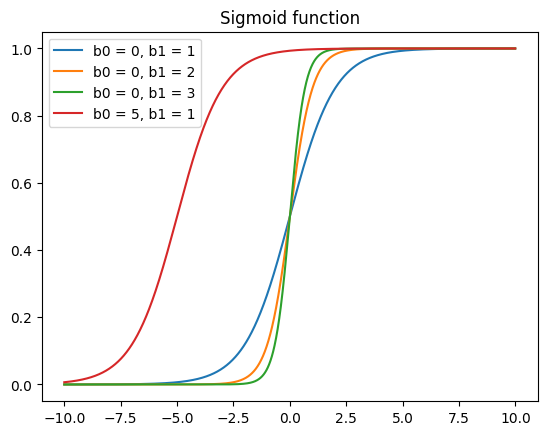

In [4]:
x = np.arange(-10, 10, 0.01)

def plot(b0, b1):
    p = np.exp(b0 + b1 * x) / (1 + np.exp(b0 + b1 * x))
    label = "b0 = {}, b1 = {}".format(b0, b1)
    plt.plot(x, p, label=label)

plot(0,1)
plot(0,2)
plot(0,3)
plot(5,1)
plt.legend()
plt.title('Sigmoid function')
plt.show()

## 2. Data for Classification Task

* How is data for regression different from classification task different? 

Covid-19 Dataset collected is from March 2020 - November 2021. The target/goal is to predict the disease based on the patient state. 

<strong>Target Feature: Corona Result.</strong>

<strong>Task:</strong> apply the tools of machine learning to predict which patients got infected by Covid-19.

## 3. Load Data

In [5]:
from sqlalchemy import create_engine, text

session_engine = create_engine('sqlite:///ml-labs-data.db')

with session_engine.connect() as conn: 
    covid19_df = pd.read_sql_query(text('SELECT * FROM covid19_lab_sample'), con=conn, parse_dates=['test_date']) 
    
covid19_df.drop('index', axis=1, inplace=True)
covid19_df.head()

,test_date,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,age_60_and_above,gender,test_indication,age
0,2021-02-12,0,0,0,0,0,Positive,No,male,Other,51
1,2020-10-14,0,0,0,0,0,Positive,No,male,Other,47
2,2021-02-22,0,0,0,0,0,Positive,No,female,Contact with confirmed,35
3,2021-03-06,1,0,0,0,1,Positive,No,female,Contact with confirmed,37
4,2021-09-24,0,0,0,0,0,Positive,No,female,Contact with confirmed,51


In [6]:
covid19_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   test_date            2000 non-null   datetime64[ns]
 1   cough                2000 non-null   int64         
 2   fever                2000 non-null   int64         
 3   sore_throat          2000 non-null   int64         
 4   shortness_of_breath  2000 non-null   int64         
 5   head_ache            2000 non-null   int64         
 6   corona_result        2000 non-null   object        
 7   age_60_and_above     2000 non-null   object        
 8   gender               2000 non-null   object        
 9   test_indication      1781 non-null   object        
 10  age                  2000 non-null   int64         
dtypes: datetime64[ns](1), int64(6), object(4)
memory usage: 172.0+ KB


## 3.1 Exploratory data analysis (EDA)

An approach of analyzing data sets to summarize their main characteristics, often using statistical graphics and other data visualization methods (i.e matplotlib, distribution plot ..)<br> 
Today we are going to try a tool called [ydata-profiling](https://github.com/ydataai/ydata-profiling). It can be easily be installed with:
1. pip: `pip3 install ydata-profiling`  
1. conda: `conda install -c conda-forge ydata-profiling
`

**Note:** All that is done by pandas profilling can be easily be achieved with pandas, matplotlib and numpy

In [263]:
import ydata_profiling

# Create the data profile report
profileReport = ydata_profiling.profile_report.ProfileReport(covid19_df)
profileReport.to_file('covid_profile.html')

## 3.2 Data preprocessing
1. How to deal with missing values? 
1. How to deal with categorical data? 
1. Is data scaling needed? 

<span style="color:red">TASK: Split data to train and test</span> <br>
<span style="color:red">TASK: Impute missing values</span> <br>
<span style="color:red">TASK: Encode categorical features</span> <br>
<span style="color:red">TASK: Use min-max scaler for feature scaling </span> <br>

In [7]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

target = 'corona_result'


#Select features 
covid19_df.drop(['test_date'], axis = 1, inplace=True)

# Encode the target label 
target_encoding = {'Negative':0, 'Positive':1}
covid19_df[target] = covid19_df[target].apply(lambda x : target_encoding.get(x))

# Split data to train and test
x_train, x_test, y_train, y_test = train_test_split(covid19_df.drop(columns=target), covid19_df[target])

In [8]:
# imputing missing values
imputer = SimpleImputer(missing_values=None, strategy='most_frequent')

# fit the imputer.
imputer = imputer.fit(x_train)
x_train = pd.DataFrame(imputer.transform(x_train), columns=x_train.columns, index=x_train.index)
x_test = pd.DataFrame(imputer.transform(x_test), columns=x_test.columns, index=x_test.index)

In [9]:
# encode categorical features
def new_ohe(df, cat_names, encoder) -> pd.DataFrame:
    return pd.concat([df.drop(columns=cat_names), pd.DataFrame(encoder.transform(df[cat_names]), 
                                                                columns=encoder.get_feature_names_out(),
                                                                index=df.index)], 
                                                                axis=1)


features_to_encode = ['test_indication', 'age_60_and_above', 'gender']
encoder = OneHotEncoder(drop='first', sparse_output=False).fit(x_train[features_to_encode])
x_train = new_ohe(x_train, features_to_encode, encoder)
x_test = new_ohe(x_test, features_to_encode, encoder)

In [10]:
x_train.columns

Index(['cough', 'fever', 'sore_throat', 'shortness_of_breath', 'head_ache',
       'age', 'test_indication_Contact with confirmed',
       'test_indication_Other', 'age_60_and_above_Yes', 'gender_male'],
      dtype='object')

In [11]:
scaler = MinMaxScaler()
scaler.fit(x_train)

x_train = pd.DataFrame(scaler.transform(x_train), columns=scaler.get_feature_names_out(), index=x_train.index)
x_test = pd.DataFrame(scaler.transform(x_test), columns=scaler.get_feature_names_out(), index=x_test.index)

In [12]:
x_train.describe()

,cough,fever,sore_throat,shortness_of_breath,head_ache,age,test_indication_Contact with confirmed,test_indication_Other,age_60_and_above_Yes,gender_male
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000
mean,0.115333,0.111333,0.042667,0.010667,0.111333,0.344977,0.200000,0.797333,0.122667,0.495333
std,0.319530,0.314649,0.202172,0.102762,0.314649,0.233716,0.400133,0.402120,0.328164,0.500145
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.154930,0.000000,1.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.323944,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.478873,0.000000,1.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## 4 Build, Train and Test Model

Now we are ready to see Logistic Regression in practice.

<span style="color:red">Task : Fit Logistic Regression  </span> <br>
<span style="color:red">Task : Output Accuracy, Precision, and Recall scores on test set </span>

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
# fit Logistic Regression
clf = LogisticRegression(random_state=42).fit(x_train, y_train)
y_test_pred = clf.predict(x_test)

# calculate metrics
print('Testing accuracy = {}'.format(metrics.accuracy_score(y_test, y_test_pred)))
print('Testing precision = {}'.format(metrics.precision_score(y_test, y_test_pred)))
print('Testing recall = {}'.format(metrics.recall_score(y_test, y_test_pred)))

Testing accuracy = 0.738
Testing precision = 0.8757763975155279
Testing recall = 0.5595238095238095


## 5. Prediction Results Interpretation & Model perfomence Measurement

1. looking at Logistic Regression Coefficients
2. Prediction threshold

### Task : 
1. Looking at Logistic Regression Coefficients

In [17]:
clf.coef_

array([[ 0.89005835,  1.56413231,  1.37895886,  1.01529549,  1.77675004,
        -0.08018044,  1.19699411, -1.15384615, -0.13123878,  0.28193672]])

In [15]:
{col: abs(w)  for col, w in zip(list(x_train.columns), clf.coef_[0])}

{'cough': np.float64(0.890058346095822),
 'fever': np.float64(1.5641323141819385),
 'sore_throat': np.float64(1.3789588616752582),
 'shortness_of_breath': np.float64(1.0152954890422539),
 'head_ache': np.float64(1.7767500373145833),
 'age': np.float64(0.0801804371452314),
 'test_indication_Contact with confirmed': np.float64(1.1969941108517457),
 'test_indication_Other': np.float64(1.153846146280547),
 'age_60_and_above_Yes': np.float64(0.13123878313177528),
 'gender_male': np.float64(0.28193672036057776)}

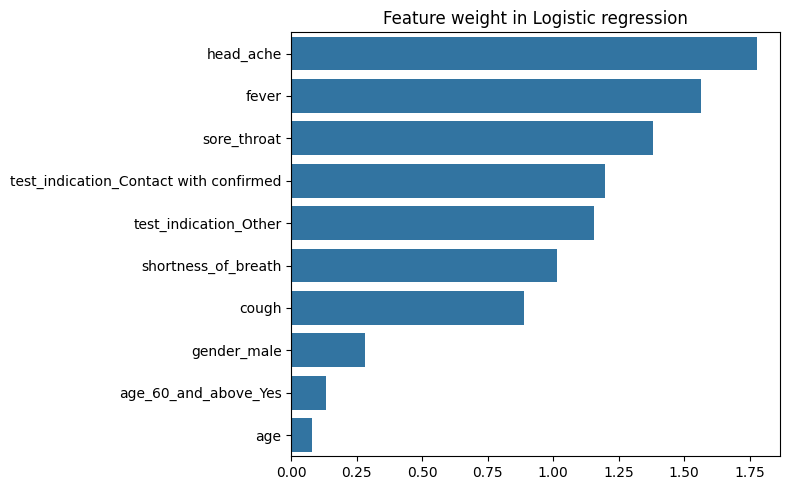

In [14]:
importance_features = {col: abs(w)  for col, w in zip(list(x_train.columns), clf.coef_[0])}
importance_features = dict(sorted(importance_features.items(), key=lambda x:x[1], reverse=True))

plt.subplots(figsize=(8,5))
sns.barplot(importance_features, 
            orient='h',
           ).set_title('Feature weight in Logistic regression')
plt.tight_layout()
plt.show()

1. Calculate Accuracy, Precision, and Recall values for each of the given threshold values and plot them.

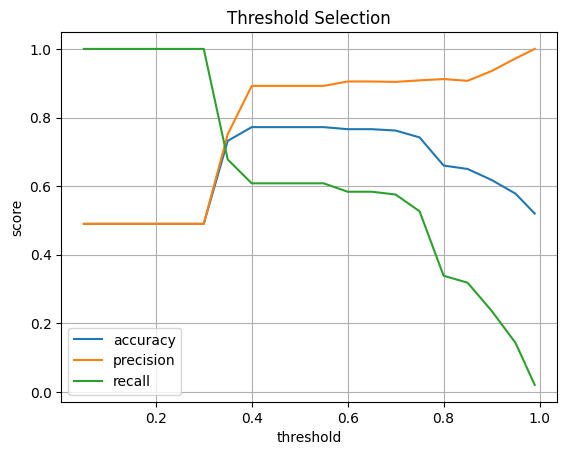

In [28]:
thresholds = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,.7,.75,.8,.85,.9,.95,.99]
pred_proba = clf.predict_proba(x_test)

results = [[],[],[]]
for i in thresholds:
    y_test_pred_thr = np.where(pred_proba[:, 1] > i, 1, 0)
    results[0].append(metrics.accuracy_score(y_test, y_test_pred_thr)) # accuracy 
    results[1].append(metrics.precision_score(y_test, y_test_pred_thr)) # precision
    results[2].append(metrics.recall_score(y_test, y_test_pred_thr)) # recall
    
plt.plot(thresholds, results[0], label = 'accuracy')   
plt.plot(thresholds, results[1], label = 'precision')   
plt.plot(thresholds, results[2], label = 'recall')
plt.title('Threshold Selection')
plt.xlabel('threshold')
plt.ylabel('score')
plt.legend()
plt.grid()

# Confusion matrix

1. Why one may need confusion matrix? 
2. What new information does it show? <br><br>

<table><tr><td>
<img align='center' src='https://static.packt-cdn.com/products/9781838555078/graphics/C13314_06_05.jpg' style='width: 350px;'>
</td><td>
<img src='https://scikit-learn.org/stable/_images/sphx_glr_plot_confusion_matrix_002.png' style='width: 400px;'></td></tr></table>
<br>


<span style="color:red">Task: Implement a confussion matrix method from scratch using python list and numpy</span>

In [29]:
def calc_confusion_matrix(true_labels, pred_labels):
    """Compute confusion matrix to evaluate the accuracy of a classification
    
    Parameters
    ----------
    true_labels : array-like of shape (n_samples,)
        Ground truth (correct) target values.
    pred_labels : array-like of shape (n_samples,)
        Estimated targets as returned by a classifier.
    """
    num_labels = np.unique(true_labels).size
    cm = np.zeros((num_labels, num_labels), dtype=int)
    for a,p in zip(true_labels, pred_labels):
        cm[a][p] += 1
    return cm

In [30]:
## computing confusion matrix
y_true = [2, 0, 2, 2, 0, 1]
y_pred = [0, 0, 2, 2, 0, 2]
print("Confusion Matrix for Test 1")
print(calc_confusion_matrix(y_true, y_pred))

covid_test_cm = calc_confusion_matrix(y_test, clf.predict(x_test))
print('Confusion Matrix for Covid-19:\n', covid_test_cm, '\n')

Confusion Matrix for Test 1
[[2 0 0]
 [0 0 1]
 [1 0 2]]
Confusion Matrix for Covid-19:
 [[237  18]
 [ 96 149]] 



## <center>Self-Practice  Task</center>

* Using `covid19_self_practice` table dataset given to you.
    1. Split the data to train and test set (80% training). 
    1. Fill missing values
    1. Encode categorical features
    1. Create new features from the existing features
    1. Train a logistic regression model that will predict if a person is infected by COvid-19 `(corona_result)`.
    1. Select the optimal prediction threshold
    1. Calculate Accuracy, Precision, and Recall values for each of the given threshold values and plot them. 

In [64]:
from sqlalchemy import create_engine, text

session_engine = create_engine('sqlite:///ml-labs-data.db')

with session_engine.connect() as conn: 
    covid19_df = pd.read_sql_query(text('SELECT * FROM covid19_self_practice'), con=conn, parse_dates=['test_date']) 
    
covid19_df.drop(['index','medical_id'], axis=1, inplace=True)
covid19_df.head()

,test_date,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,age_60_and_above,gender,test_indication,age
0,2021-01-03,0,0,0,0,0,Negative,Yes,male,Other,87
1,2020-10-08,0,0,0,0,0,Negative,No,male,Other,24
2,2021-02-07,0,0,0,0,0,Positive,No,female,Contact with confirmed,57
3,2020-10-12,0,0,0,0,0,Negative,Yes,female,Other,63
4,2020-10-29,0,0,0,0,0,Negative,No,female,Other,39


In [65]:
covid19_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11000 entries, 0 to 10999
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   test_date            11000 non-null  datetime64[ns]
 1   cough                11000 non-null  int64         
 2   fever                11000 non-null  int64         
 3   sore_throat          11000 non-null  int64         
 4   shortness_of_breath  11000 non-null  int64         
 5   head_ache            11000 non-null  int64         
 6   corona_result        11000 non-null  object        
 7   age_60_and_above     11000 non-null  object        
 8   gender               10534 non-null  object        
 9   test_indication      10543 non-null  object        
 10  age                  11000 non-null  int64         
dtypes: datetime64[ns](1), int64(6), object(4)
memory usage: 945.4+ KB


### Split the data to train and test set (80% training). 

In [66]:
from sklearn.model_selection import train_test_split

target = 'corona_result'
x_train, x_test, y_train, y_test = train_test_split(covid19_df.drop(columns=target), covid19_df[target], 
                                                    train_size=0.8, random_state=42)

# Encode the target label 
target_encoding = {'Negative':0, 'Positive':1}
y_train = y_train.apply(lambda y: target_encoding.get(y))
y_test = y_test.apply(lambda y: target_encoding.get(y))

([<matplotlib.patches.Wedge at 0x79cf81a52e10>,
 [Text(-1.0597599742642667, 0.29480297988215937, 'Negative'),
  Text(1.0597601406096093, -0.29480238190201485, 'Positive')],
 [Text(-0.5780508950532364, 0.1608016253902687, '91.36'),
  Text(0.5780509857870595, -0.1608012992192808, '8.64')])

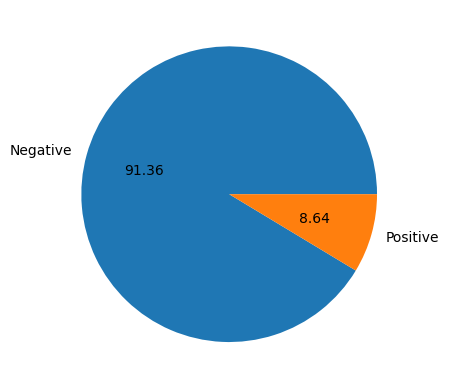

In [67]:
plt.pie(y_test.value_counts(), 
        labels={'Negative':0, 'Positive':1}, 
        autopct='%.2f')

We have imbalanced data

### Fill missing values

In [72]:
# Fill missing values
from sklearn.impute import SimpleImputer


imputer = SimpleImputer(missing_values=None, strategy='most_frequent')
# fit the imputer.
imputer = imputer.fit(x_train)
x_train_imputed = pd.DataFrame(imputer.transform(x_train), columns=x_train.columns)
x_test_imputed = pd.DataFrame(imputer.transform(x_test), columns=x_train.columns)

In [73]:
x_train_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8800 entries, 0 to 8799
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   test_date            8800 non-null   datetime64[ns]
 1   cough                8800 non-null   object        
 2   fever                8800 non-null   object        
 3   sore_throat          8800 non-null   object        
 4   shortness_of_breath  8800 non-null   object        
 5   head_ache            8800 non-null   object        
 6   age_60_and_above     8800 non-null   object        
 7   gender               8800 non-null   object        
 8   test_indication      8800 non-null   object        
 9   age                  8800 non-null   object        
dtypes: datetime64[ns](1), object(9)
memory usage: 687.6+ KB


In [74]:
int_cols = ['cough', 'fever', 'sore_throat', 'shortness_of_breath', 'head_ache', 'age']
x_train_imputed[int_cols] = x_train_imputed[int_cols].astype('int')

In [75]:
x_train_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8800 entries, 0 to 8799
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   test_date            8800 non-null   datetime64[ns]
 1   cough                8800 non-null   int64         
 2   fever                8800 non-null   int64         
 3   sore_throat          8800 non-null   int64         
 4   shortness_of_breath  8800 non-null   int64         
 5   head_ache            8800 non-null   int64         
 6   age_60_and_above     8800 non-null   object        
 7   gender               8800 non-null   object        
 8   test_indication      8800 non-null   object        
 9   age                  8800 non-null   int64         
dtypes: datetime64[ns](1), int64(6), object(3)
memory usage: 687.6+ KB


### Encode categorical features

In [97]:
features_to_encode = ['test_indication', 'age_60_and_above', 'gender']
x_train_imputed[features_to_encode].nunique()

test_indication     3
age_60_and_above    2
gender              2
dtype: int64

In [98]:
# encode categorical features
def new_ohe(df, cat_names, encoder) -> pd.DataFrame:
    return pd.concat([df.drop(columns=cat_names), pd.DataFrame(encoder.transform(df[cat_names]), 
                                                                columns=encoder.get_feature_names_out(),
                                                                index=df.index)], 
                                                                axis=1)


encoder = OneHotEncoder(drop='first', sparse_output=False).fit(x_train_imputed[features_to_encode])
x_train_encoded = new_ohe(x_train_imputed, features_to_encode, encoder)
x_test_encoded = new_ohe(x_test_imputed, features_to_encode, encoder)

In [99]:
x_train_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8800 entries, 0 to 8799
Data columns (total 11 columns):
 #   Column                                  Non-Null Count  Dtype         
---  ------                                  --------------  -----         
 0   test_date                               8800 non-null   datetime64[ns]
 1   cough                                   8800 non-null   int64         
 2   fever                                   8800 non-null   int64         
 3   sore_throat                             8800 non-null   int64         
 4   shortness_of_breath                     8800 non-null   int64         
 5   head_ache                               8800 non-null   int64         
 6   age                                     8800 non-null   int64         
 7   test_indication_Contact with confirmed  8800 non-null   float64       
 8   test_indication_Other                   8800 non-null   float64       
 9   age_60_and_above_Yes                    8800 non-nul

### Create new features from the existing features

In [100]:
# Create new features from the existing features
x_train_encoded['month'] = x_train_encoded['test_date'].dt.month
x_train_encoded['day'] = x_train_encoded['test_date'].dt.day
x_train_encoded['weekday'] = x_train_encoded['test_date'].dt.weekday
x_train_encoded.drop(columns='test_date', inplace=True)


x_test_encoded['month'] = x_test_encoded['test_date'].dt.month
x_test_encoded['day'] = x_test_encoded['test_date'].dt.day
x_test_encoded['weekday'] = x_test_encoded['test_date'].dt.weekday
x_test_encoded.drop(columns='test_date', inplace=True)

### Train a logistic regression model that will predict if a person is infected by COvid-19 `(corona_result)`.

In [101]:
scaler = MinMaxScaler()
scaler.fit(x_train_encoded)

x_train_scaled = pd.DataFrame(scaler.transform(x_train_encoded), columns=scaler.get_feature_names_out(), index=x_train_encoded.index)
x_test_scaled = pd.DataFrame(scaler.transform(x_test_encoded), columns=scaler.get_feature_names_out(), index=x_test_encoded.index)


In [102]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
# fit Logistic Regression
clf = LogisticRegression(random_state=42, class_weight='balanced').fit(x_train_scaled, y_train)
y_test_pred = clf.predict(x_test_scaled)

# calculate metrics
print('Testing accuracy = {}'.format(metrics.accuracy_score(y_test, y_test_pred)))
print('Testing precision = {}'.format(metrics.precision_score(y_test, y_test_pred)))
print('Testing recall = {}'.format(metrics.recall_score(y_test, y_test_pred)))

Testing accuracy = 0.8822727272727273
Testing precision = 0.37809187279151946
Testing recall = 0.5631578947368421


### Select the optimal prediction threshold

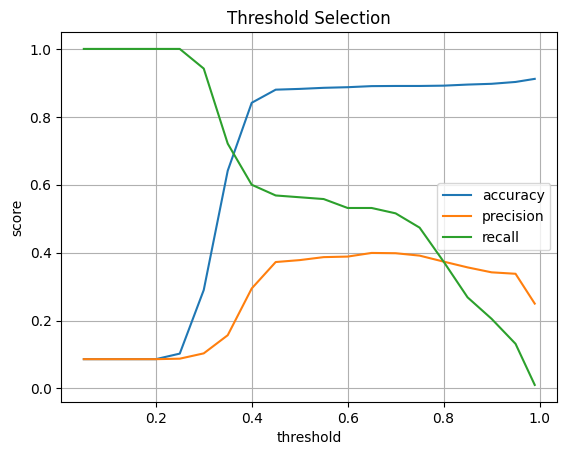

In [103]:
# Calculate Accuracy, Precision, and Recall values for each of the given threshold values and plot them.
thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
thresholds = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,.7,.75,.8,.85,.9,.95,.99]

pred_proba = clf.predict_proba(x_test_scaled)

results = [[],[],[]]
for i in thresholds:
    y_test_pred_thr = np.where(pred_proba[:, 1] > i, 1, 0)
    results[0].append(metrics.accuracy_score(y_test, y_test_pred_thr)) # accuracy 
    results[1].append(metrics.precision_score(y_test, y_test_pred_thr)) # precision
    results[2].append(metrics.recall_score(y_test, y_test_pred_thr)) # recall
    
plt.plot(thresholds, results[0], label = 'accuracy')   
plt.plot(thresholds, results[1], label = 'precision')   
plt.plot(thresholds, results[2], label = 'recall')
plt.title('Threshold Selection')
plt.xlabel('threshold')
plt.ylabel('score')
plt.legend()
plt.grid()



### Calculate Accuracy, Precision, and Recall values for each of the given threshold values and plot them. 

Testing accuracy = 0.6413636363636364
Testing precision = 0.15693012600229095
Testing recall = 0.7210526315789474
Testing f1_score = 0.257761053621825


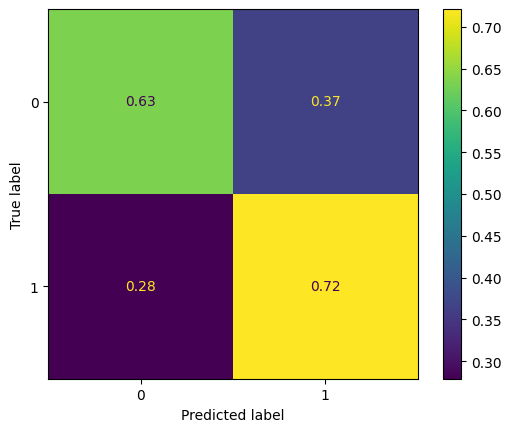

In [105]:
# Select the optimal prediction threshold
optimal_thresholds = 0.35

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


pred_proba = clf.predict_proba(x_test_scaled)
y_pred = np.where(pred_proba[:, 1] > optimal_thresholds, 1, 0)

cm = confusion_matrix(y_test, y_pred, labels=clf.classes_, 
                      normalize='true'
                      )
ConfusionMatrixDisplay(cm, display_labels=clf.classes_).plot()

# calculate metrics
print('Testing accuracy = {}'.format(metrics.accuracy_score(y_test, y_pred)))
print('Testing precision = {}'.format(metrics.precision_score(y_test, y_pred)))
print('Testing recall = {}'.format(metrics.recall_score(y_test, y_pred)))
print('Testing f1_score = {}'.format(metrics.f1_score(y_test, y_pred)))